<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hamiltonian Monte Carlo (HMC) was presented in class as a way to sample from high dimensional distirbutions for the purposes of integration estimation (hence, the name "Monte Carlo").
- A primary high dimensional distribution statisticians are interested in sampling from is a posterior distribution; so, naturally, HMC is used for Bayesian inference.

`PyMC` is a popular (`python` embedded) ***probabilistic programming*** language which leverages (the "No U-Turn Sampler" NUTS implementation of) HMC, so we'll here see how HMC is used in practice to provide samples from high dimensional distributions. While `PyMC` posterior inference is not general targetted at integral estimation, we could easily imagine contriving a "posterior distribution" using `PyMC` and then averaging the (HMC) posterior samples for the purposes integral estimation.

- So, posterior analysis and integral estimation end up requiring the same HMC machinery but then just use it for slightly different purposes.

# Eight Schools

Eight Schools is the classical example of a hierarchical "random effects" Bayesian model.

- 8 Schools have different average levels of achievement ($y$)
- but also different uncertainty in their estimation ($\sigma$)

> Google "stan eight schools" to find out more, but we'll start from the current [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#the-eight-schools-model) updated from a [previous version](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html).

In [2]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
import pymc as pm

In [4]:
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

This hierarchy seeks to estimate "true levels of achievement" $\theta_i$ given ($\sigma_i$) noisy observation $y_i$ assuming that there's some variabiltiy over $\theta_i$ but all come from the same (normal) "random effects" distribution with unknown mean and variance.

Inference will consist of posterior distributions for $\theta_i$ (and a normal distributional characterization of these 8 values given by posterior distributions over $\mu$ and $\tau$).

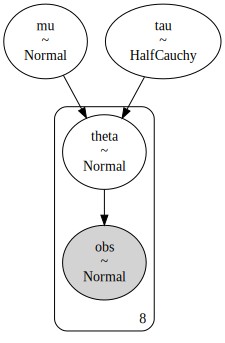

In [5]:
pm.model_to_graphviz(Centered_eight)

In [6]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [7]:
# We can get some more information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [8]:
# We now see that the NUTS implementation (version of HMC) is being used to
# sample from the posterior distributions of our parameters [mu, tau, theta]
SEED = [20100420, 20134234]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 33 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


Divergences here mean that $\tau$ was sampled with a small value so that previous $\theta_i$ no longer appear to be reasonable values under $\mathcal{N}(\mu, \tau)$. Their density evaluation is now extremely small (probably even numerically $0$). We have therefore "flown off" the mass of our target distribution. But we can fix this with a different parameterization.

In [9]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [10]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta_t]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [18]:
import arviz as az
az.summary(fit_C, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.30,3.39,-1.98,10.55,0.14,0.10,622.77,372.14,1.01
theta[0],6.60,6.25,-3.97,19.07,0.22,0.16,538.46,1066.22,1.01
theta[1],5.01,5.07,-4.28,14.87,0.15,0.10,978.36,2058.62,1.00
theta[2],3.68,5.66,-7.11,14.17,0.12,0.09,1575.05,3789.16,1.00
theta[3],4.76,5.13,-5.04,14.36,0.15,0.11,964.74,3571.47,1.00
theta[4],3.36,5.07,-6.59,12.71,0.12,0.09,1673.49,2949.01,1.00
theta[5],3.85,5.12,-5.84,13.58,0.11,0.08,1769.35,3374.08,1.00
theta[6],6.71,5.47,-2.65,17.48,0.25,0.17,415.23,977.87,1.01
theta[7],4.86,5.70,-5.74,16.01,0.13,0.09,1248.42,3856.95,1.00
tau,4.30,3.31,0.84,10.22,0.17,0.12,128.66,95.34,1.02


In [17]:
az.summary(fit_NC, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.40,3.30,-1.71,10.69,0.03,0.02,11120.12,6319.82,1.0
theta_t[0],0.33,1.00,-1.52,2.25,0.01,0.01,12332.60,6677.65,1.0
theta_t[1],0.11,0.93,-1.66,1.83,0.01,0.01,13263.21,7097.14,1.0
theta_t[2],-0.08,0.98,-1.97,1.70,0.01,0.01,15199.46,6188.73,1.0
theta_t[3],0.07,0.93,-1.72,1.83,0.01,0.01,14951.30,7291.90,1.0
theta_t[4],-0.15,0.92,-1.87,1.62,0.01,0.01,14707.69,7426.50,1.0
theta_t[5],-0.08,0.94,-1.78,1.75,0.01,0.01,13359.94,7108.87,1.0
theta_t[6],0.35,0.95,-1.43,2.15,0.01,0.01,11562.53,7108.09,1.0
theta_t[7],0.07,0.99,-1.78,1.91,0.01,0.01,15762.83,6727.60,1.0
tau,3.58,3.20,0.00,9.18,0.04,0.03,5121.40,3807.87,1.0


The `theta = pm.Deterministic("theta", mu + tau * theta_tilde)` line above also shows that probabilistic programming can introduce formulas into our hierarchical specifications... so you might now be able to imagine embedding a linear model into some of our distributional specifications...

There are two things that matter for HMC performance:
1. Metropolis-Hastings Acceptance Rates
2. Autocorrelation in the Markov Chain
  - How far was the proposal able to move away from the current state?
  - The further away, the more independent, and the greater the effective sample size

Below we examine some of the HMC performance diagnostics available from
- https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html


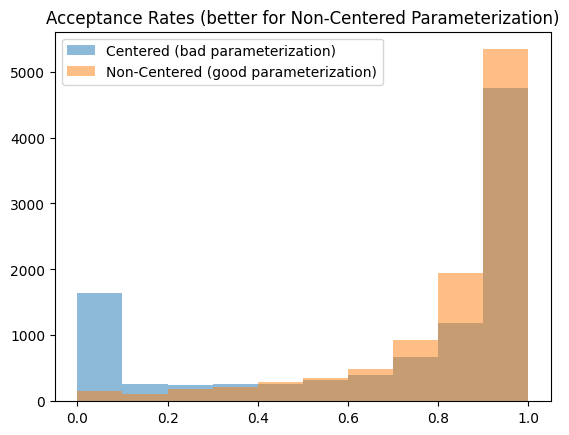

In [11]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

In [12]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


Our demonstration in this notebook will stop here, but if you're interested in seeing more about what a full Bayesian posterior inference analysis looks like, have a look at the [getting started with `PyMC`](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) materials [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#posterior-analysis)

You could also follow up on some further examination of the specification of the "Eight Schools Model" [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html) and can also return to the more detailed analysis [here](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#the-eight-schools-model).

If you have a look at the "Introductory Overview of PyMC" notebook, you'll see "Section Navigation" with a link to [GLM: Linear regression](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html). This might be a good place to look at first when you're starting your homework.  You will also likely find the [`PyMC` Example Gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) useful... especially the section titled [generalized linear models](https://www.pymc.io/projects/examples/en/latest/gallery.html#generalized-linear-models)...


**Centered:**

a) ESS: All variables have ESS of less than one-third of the actual sample size, indicating poor algorithmic efficiency

b) Convergence measures: All variables converge (r_hat < 1.05)

c) Divergences: The Centered model suffers from 71 and 283 divergences for the first and second chain respectively, which is above threshold.

d) MH acceptance rates: There is a significant amount of instances with denied proposals, signifying poor parameterization.

e) Received NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0.

This warning shows that the defualt argument for nopython is currently False, but will change to true in an upcoming update. Future use of this function may need to specify the argument for the same results.

**Uncentered:**

a) Most variables have higher ESS than the actual sample number, meaning that the algorithm is highly efficient. Only the estimate for tau has a lower ESS, which is still high compared to the centered model.

b) All variables converge (r_hat < 1.05)

c) The uncentered model only has 5 and 3 divergences, which is under an acceptable threshold.

d) The acceptance rates are high and have are largely concentrated between 0.8 and 1, indicating more optimal exploration.

e) Same as above

For the uncentered model, since the shape of the theta distribution is no longer dependent on tau, changes in tau will no longer make theta highly volatile when sampling. As a result, the curvature will not be as high as the centered model and it should more closely follow the empirical energy distribution.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


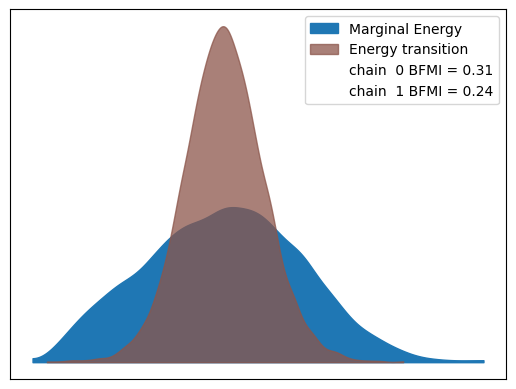

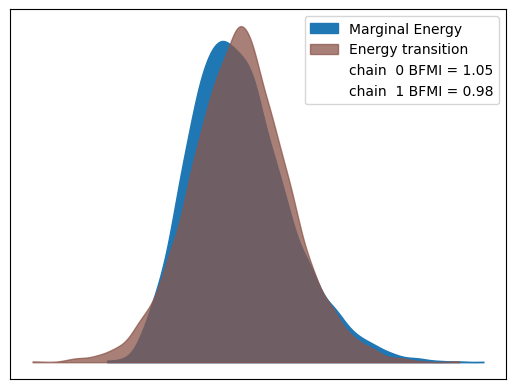

In [19]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The first figure shows the centered model, where an excessive curvature can be seen. The inefficiency of the parameterization results in deviation from the theoretical energy contour.

In the case of the uncentered model, the observed distribution aligns more closely with the expected distribution. The conservation of energy indicates that the model is highly efficient and approximates Hamiltonian dynamics.

This aligns with our previous theory on the comparative effectiveness of the two models.